## aggregate

> This module aggregates the downloaded data into the respective output dataframes.

In [1]:
#| default_exp aggregate


In [2]:
#| hide
from nbdev.showdoc import *

We prototyped the code in this module using a Jupyter notebook. The notebook is available in `notes/prototypes/learning_aggregations_w_michelle_20250328.ipynb`. The code in this module is a cleaned-up version of the code in that notebook. The notebook contains additional comments and explanations of the code, which may be helpful for understanding the code in this module.

The basic process is as follows:

1. Load the netCDF data in memory
2. Statistically aggregate the hourly data to daily data per exposure using resample()
3. Write out the data to tiff
4. Read the tiff data back in
5. Read in the shapefile that defines the healthsheds
6. Spatially aggregate the exposure data to the healthsheds
7. Quality check the aggregations
8. Write out final aggregations to tiff

In [1]:
#| export

import tempfile
import rasterio
import hydra
import argparse
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from typing import Optional, Tuple
from pyprojroot import here
from hydra import initialize, compose
from omegaconf import OmegaConf, DictConfig
from tqdm import tqdm
from math import ceil, floor
from rasterstats.io import Raster
from rasterstats.utils import boxify_points, rasterize_geom

try: from era5_sandbox.core import GoogleDriver, _get_callable, describe, ClimateDataFileHandler, kelvin_to_celsius
except: from core import GoogleDriver, _get_callable, describe, ClimateDataFileHandler, kelvin_to_celsius

In [2]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

We're going to write a function that aggregates the data for a single exposure from a file. This file should be the single month data we got from the previous step in the pipeline.

In [3]:
eg_file = here() / "data/input/nepal_2017_11.nc"

In [4]:
#| export 

def resample_netcdf(
        fpath: str, # Path to the netCDF file.
        resample: str = "1D", # Resampling frequency (e.g., '1H', '1D')
        agg_func: callable = np.mean, # Aggregation function (e.g., np.mean, np.sum).
        time_dim: str = "valid_time", # Name of the time dimension in the dataset.
        **xr_open_kwargs  # keywords for python's xarray module
    ) -> xr.Dataset:   
    """
    Resample a netCDF file to a specified frequency and aggregation method.
    
    Args:
        fpath (str): Path to the netCDF file.
        resample (str): Resampling frequency (e.g., '1H', '1D').
        agg_func (callable): Aggregation function (e.g., np.mean, np.sum).
    
    Returns:
        xarray.Dataset: Resampled dataset.
    """

    ds = xr.open_dataset(fpath, **xr_open_kwargs)

    if callable(agg_func):
        # Use xarray's reduce method with the callable
        return ds.resample({time_dim: resample}).reduce(agg_func)
    else:
        raise TypeError("agg_func must be a callable function like np.mean, np.max, etc.")

In [5]:
var = 'swvl1'
agg_func = _get_callable(cfg['aggregation']['aggregation'][var]['hourly_to_daily'][0]['function'])

In [6]:
with ClimateDataFileHandler(eg_file) as handler:

    ds_path = handler.get_dataset("instant")
    resampled_data = resample_netcdf(ds_path, agg_func=agg_func)

I'm going to use a dataclass to represent the tiff data. This will allow us to easily pass around the data and metadata associated with the tiff file. Why? Because I can, lol (I've never used dataclasses and I'm curious about them). ChatGPT thinks this will make the code cleaner and easier to read.

In [7]:
#| export

@dataclass
class RasterFile:
    path: str
    band: int # note that this is 1-indexed
    data: Optional[np.ndarray] = field(default=None, init=False)
    transform: Optional[rasterio.Affine] = field(default=None, init=False)
    crs: Optional[str] = field(default=None, init=False)
    nodata: Optional[float] = field(default=None, init=False)
    bounds: Optional[Tuple[float, float, float, float]] = field(default=None, init=False)

    def load(self):
        """Load raster data and basic metadata."""
        with rasterio.open(self.path) as src:
            self.data = src.read(self.band)  # each day gets one rasterfile
            self.transform = src.transform
            self.crs = src.crs
            self.nodata = src.nodata
            self.bounds = src.bounds
        return self

    def shape(self) -> Optional[Tuple[int, int]]:
        """Return the shape of the raster data."""
        return self.data.shape if self.data is not None else None

    def __str__(self):
        return f"RasterFile(path='{self.path}', shape={self.shape()}, crs='{self.crs}')"

Next, a function to write and read the netCDF to tiff:

In [8]:
#| export

def netcdf_to_tiff(
    ds: xr.Dataset, # The aggregated xarray dataset to convert.    
    band: int,      # The day to rasterise; 1 indexed just like human english
    variable: str, # The variable name to convert.
    crs: str = "EPSG:4326", # Coordinate reference system (default is WGS84).    
    ):

    """
    Convert a netCDF file to a GeoTIFF file.
    
    Args:
        fpath (str): Path to the netCDF file.
        output_path (str): Path to save the output GeoTIFF file.
        variable_name (str): Name of the variable to convert.
        time_index (int): Index of the time dimension to extract.
    """

    with tempfile.TemporaryDirectory() as tmpdirname:

        # Select the variable and time index
        variable = ds[variable]
        ds_ = variable.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
        ds_ = ds_.rio.write_crs(crs)
        # Save as GeoTIFF
        ds_.rio.to_raster(f"{tmpdirname}/output.tif")
        # Load the raster file
        raster_file = RasterFile(path=f"{tmpdirname}/output.tif", band=band).load()

    return raster_file

Now to test it:

In [9]:
with ClimateDataFileHandler(eg_file) as handler:
    ds_path = handler.get_dataset("instant")
    resampled_nc = resample_netcdf(ds_path)

print(resampled_nc)
resampled_tiff = netcdf_to_tiff(
    ds=resampled_nc,
    band=28,
    variable="swvl1",
    crs="EPSG:4326"
)

<xarray.Dataset> Size: 267kB
Dimensions:     (valid_time: 30, latitude: 20, longitude: 37)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 160B 30.75 30.5 30.25 ... 26.5 26.25 26.0
  * longitude   (longitude) float64 296B 79.6 79.85 80.1 ... 88.1 88.35 88.6
  * valid_time  (valid_time) datetime64[ns] 240B 2017-11-01 ... 2017-11-30
Data variables:
    d2m         (valid_time, latitude, longitude) float32 89kB 261.6 ... 288.1
    t2m         (valid_time, latitude, longitude) float32 89kB 267.3 ... 293.1
    swvl1       (valid_time, latitude, longitude) float32 89kB 0.2773 ... 0.1922
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-14T20:49 GRIB to CDM+CF via cfgrib-0.9.1...


In [10]:
resampled_tiff.data.shape, resampled_tiff.transform, resampled_tiff.crs, resampled_tiff.bounds

((20, 37),
 Affine(0.25, 0.0, 79.475,
        0.0, -0.25, 30.875),
 CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 BoundingBox(left=79.475, bottom=25.875, right=88.725, top=30.875))

Super cool! The tiff file is created and the data is read back in correctly. Now we can move on to the next step, which is to aggregate the data by healthshed.

## Polygon to Raster Cells

This function was initially shared from a previous NSAPH aggregation pipeline [here](https://github.com/NSAPH-Data-Processing/air_pollution__aqdh/blob/2a8109075fe7a8fbf7c435cc34ffa97b63f5e133/utils/faster_zonal_stats.py#L17). To better understand this, here is a ChatGPT explanation of the code:

> This function, `polygon_to_raster_cells`, is doing a crucial first step in spatial alignment: it determines which raster cells are “touched” by each polygon geometry (e.g., administrative areas, watersheds, etc.).    
Essentially, this function helps figure out which pixels from a raster image fall inside each polygon (like a district, region, or shape). It does this by looking at each polygon one by one, zooming in on just the part of the raster that overlaps with that shape, and marking the pixels that are inside. This is kind of like placing a cookie cutter (the polygon) on a pixelated map (the raster) and seeing which pixels get cut.  
The result is a list where each item tells you the pixel locations that match a specific polygon. You can then use those pixel locations to pull out data from the raster, like temperatures or rainfall, and calculate statistics (like the average) for each shape. This is a key step when you want to summarize raster data within specific regions, like figuring out the average temperature in each county or how much vegetation is in each park.

In [11]:
#| export 

def polygon_to_raster_cells(
    vectors,
    raster,
    nodata=None,
    affine=None,
    all_touched=False,
    verbose=False,
    **kwargs,
):
    """Returns an index map for each vector geometry to indices in the raster source.

    Parameters
    ----------
    vectors: list of geometries

    raster: ndarray

    nodata: float

    affine: Affine instance

    all_touched: bool, optional
        Whether to include every raster cell touched by a geometry, or only
        those having a center point within the polygon.
        defaults to `False`

    Returns
    -------
    dict
        A dictionary mapping vector the ids of geometries to locations (indices) in the raster source.
    """

    cell_map = []

    with Raster(raster, affine, nodata) as rast:
        # used later to crop raster and find start row and col
        min_lon, dlon = affine.c, affine.a
        max_lat, dlat = affine.f, -affine.e
        H, W = rast.shape

        for geom in tqdm(vectors, disable=(not verbose)):
            if "Point" in geom.geom_type:
                geom = boxify_points(geom, rast)

            # find geometry bounds to crop raster
            # the raster and geometry must be in the same lon/lat coordinate system
            start_row = max(0, min(H - 1, floor((max_lat - geom.bounds[3]) / dlat)))
            start_col = min(W - 1, max(0, floor((geom.bounds[0] - min_lon) / dlon)))
            end_col = max(0, min(W - 1, ceil((geom.bounds[2] - min_lon) / dlon)))
            end_row = min(H - 1, max(0, ceil((max_lat - geom.bounds[1]) / dlat)))
            geom_bounds = (
                min_lon + dlon * start_col,  # left
                max_lat - dlat * end_row - 1e-12,  # bottom
                min_lon + dlon * end_col + 1e-12,  # right
                max_lat - dlat * start_row,  # top
            )

            # crop raster to area of interest and rasterize
            fsrc = rast.read(bounds=geom_bounds)
            rv_array = rasterize_geom(geom, like=fsrc, all_touched=all_touched)
            indices = np.nonzero(rv_array)

            if len(indices[0]) > 0:
                indices = (indices[0] + start_row, indices[1] + start_col)
                assert 0 <= indices[0].min() < rast.shape[0]
                assert 0 <= indices[1].min() < rast.shape[1]
            else:
                pass  # stop here for debug

            cell_map.append(indices)

        return cell_map

To use this, we must define the polygon and raster data. The polygon data is the healthshed shapefile, and the raster data is the tiff file we created earlier. We can use the `GoogleDriver` class we defined in `core` to read in the shapefile.

In [12]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
drive = driver.get_drive()
healthsheds = driver.read_healthsheds("Nepal_Healthsheds2024.zip")

In [13]:
res_poly2cell=polygon_to_raster_cells(
    vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
    raster=resampled_tiff.data, # the raster data above
    nodata=resampled_tiff.nodata, # any intersections with no data, may have to be np.nan
    affine=resampled_tiff.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

  0%|          | 0/777 [00:00<?, ?it/s]/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
100%|██████████| 777/777 [00:00<00:00, 1161.19it/s]


The data below maps which grid entries fall into each of the regions in the shapefile (e.g. which pixel is in which state)

In [14]:
res_poly2cell[:5]

[(array([14]), array([32])),
 (array([13, 13, 14, 14]), array([33, 34, 33, 34])),
 (array([12, 13, 13, 14]), array([34, 33, 34, 33])),
 (array([15, 15]), array([33, 34])),
 (array([15, 15, 16, 16]), array([32, 33, 32, 33]))]

Last but not least, we aggregate these data to the healthshed level. We can use the `rasterstats` package to do this.

In [15]:
#| export

def aggregate_to_healthsheds(
    res_poly2cell: list, # the result of polygon_to_raster_cells    
    raster: RasterFile, # the raster data
    shapes: gpd.GeoDataFrame, # the shapes of the health sheds
    names_column: str = "fs_uid", # the unique identifier column name of the health sheds
    aggregation_func: callable = np.nanmean, # the aggregation function
    aggregation_name: str = "mean" # the name of the aggregation function
    ) -> gpd.GeoDataFrame:
    """
    Aggregate the raster data to the health sheds.
    """

    stats = []

    for indices in res_poly2cell:
        if len(indices[0]) == 0:
            # no cells found for this polygon
            stats.append(np.nan)
        else:
            cells = raster.data[indices]
            if sum(~np.isnan(cells)) == 0:
                # no valid cells found for this polygon
                stats.append(np.nan)
                continue
            else:
                # compute MEAN of valid cells
                # but this stat can be ANYTHING
                stats.append(aggregation_func(cells))

    # clean up the result into a dataframe
    stats = pd.Series(stats)
    shapes[aggregation_name] = stats
    df = pd.DataFrame(
            {"healthshed": shapes[names_column], aggregation_name: stats}
        )
    gdf = gpd.GeoDataFrame(df, geometry=shapes.geometry.values, crs=shapes.crs)
    return gdf


And now we apply it:

In [16]:
result = aggregate_to_healthsheds(
    res_poly2cell=res_poly2cell,
    raster=resampled_tiff,
    shapes=healthsheds,
    names_column="fid",
    aggregation_func=np.nanmean,
    aggregation_name="mean_soil_moisture"
)
result.head()

,healthshed,mean_soil_moisture,geometry
0,1,0.331351,"POLYGON ((87.60719 27.37069, 87.60841 27.36969..."
1,7,0.360747,"POLYGON ((88.04438 27.4203, 88.04365 27.41925,..."
2,8,0.332805,"POLYGON ((88.14528 27.67003, 88.14526 27.66966..."
3,23,0.270567,"POLYGON ((88.0766 27.03545, 88.07695 27.03533,..."
4,24,0.212768,"POLYGON ((87.76435 26.92431, 87.76435 26.924, ..."


And plot for QA:

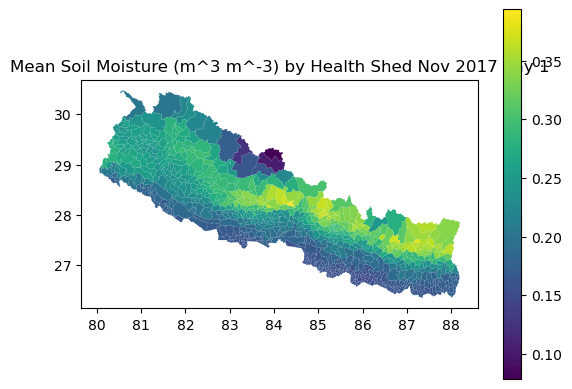

In [17]:
result.plot(column="mean_soil_moisture", legend=True)
plt.title("Mean Soil Moisture (m^3 m^-3) by Health Shed Nov 2017 day 1")
plt.show()

That looks great! The data is aggregated to the healthshed level, and we can see the differences in exposure across the healthsheds. We can also see that the data is not uniform across the healthsheds, which is what we expect.

## Tests and Main

Now we can wrap this up in a main function that will simply take in the input file and generate this output. We can also add some tests to make sure the data is aggregated correctly; tests will run automatically in this notebook.

100%|██████████| 2766/2766 [00:01<00:00, 1672.67it/s]


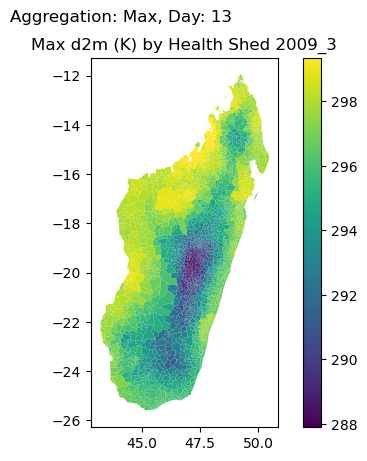

100%|██████████| 2766/2766 [00:01<00:00, 1664.84it/s]


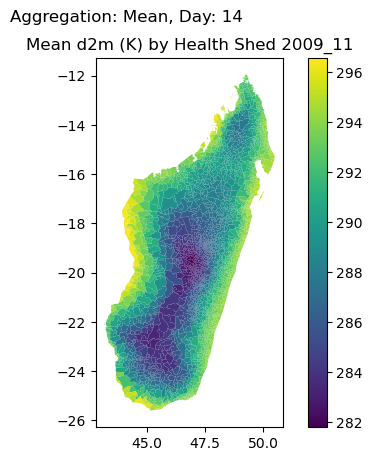

100%|██████████| 2766/2766 [00:01<00:00, 1684.77it/s]


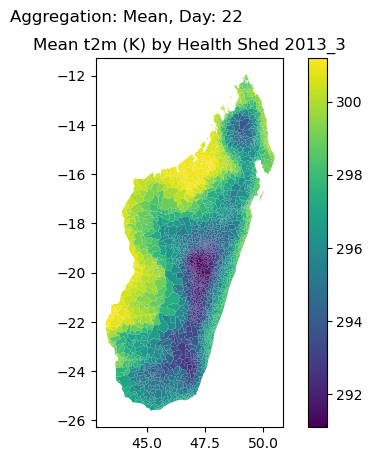

100%|██████████| 2766/2766 [00:01<00:00, 1691.20it/s]


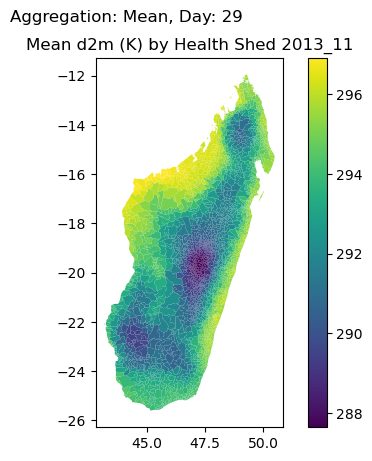

/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/li

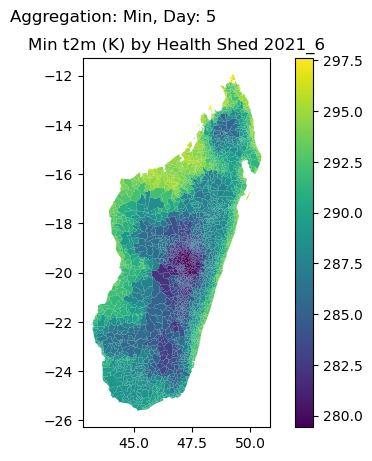

100%|██████████| 2766/2766 [00:01<00:00, 1701.19it/s]


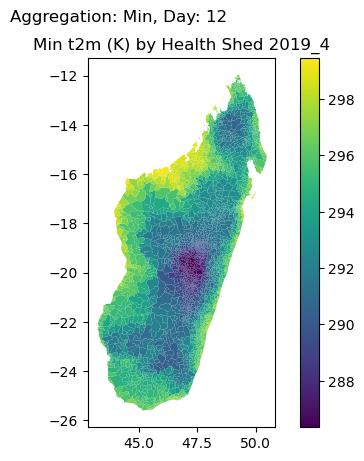

100%|██████████| 2766/2766 [00:01<00:00, 1705.77it/s]


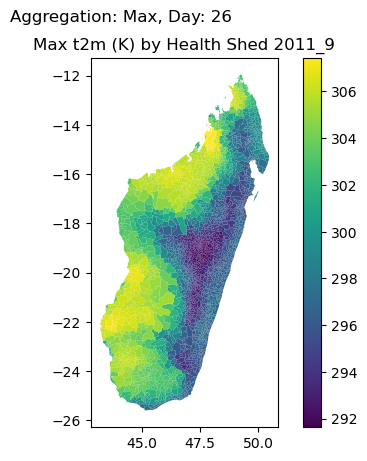

100%|██████████| 2766/2766 [00:01<00:00, 1685.08it/s]


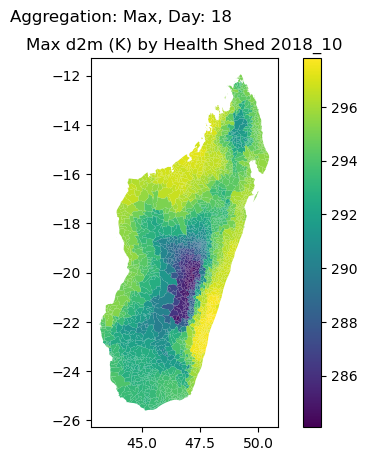

5.9 s ± 2.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

import random

variables = ["t2m", "d2m"]
years = ["20{:02d}".format(m) for m in range(9, 24)]
months = [str(m) for m in range(1, 13)]
aggregations = [
    ("Mean", np.nanmean),
    ("Max", np.nanmax),
    ("Min", np.nanmin)
]

exposure_variable = random.choice(variables)
year = random.choice(years)
month = random.choice(months)
aggregation_str, agg_func = random.choice(aggregations)
input_file = here() / "data/input/{}_{}.nc".format(year, month)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
drive = driver.get_drive()
healthsheds = driver.read_healthsheds(cfg.GOOGLE_DRIVE_AUTH_JSON.healthsheds_id)

with ClimateDataFileHandler(input_file) as handler:
    ds_path = handler.get_dataset("instant")
    resampled_nc_file = resample_netcdf(ds_path, agg_func=agg_func)

days = len(resampled_nc_file.valid_time.values)
day = random.choice(range(1, days + 1))

resampled_tiff = netcdf_to_tiff(
    ds=resampled_nc_file,
    band=day, # the day we're aggregating
    variable=exposure_variable,
    crs="EPSG:4326"
)

res_poly2cell=polygon_to_raster_cells(
    vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
    raster=resampled_tiff.data, # the raster data above
    nodata=resampled_tiff.nodata, # any intersections with no data, may have to be np.nan
    affine=resampled_tiff.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

result = aggregate_to_healthsheds(
    res_poly2cell=res_poly2cell,
    raster=resampled_tiff,
    shapes=healthsheds,
    names_column="fs_uid",
    aggregation_func=agg_func,
    aggregation_name=exposure_variable
)

result.plot(column=exposure_variable, legend=True)
plt.title("{} {} (K) by Health Shed {}".format(aggregation_str, exposure_variable, input_file.stem))
plt.suptitle("Aggregation: {}, Day: {}".format(aggregation_str, str(day)))
plt.show()

3.2 seconds per aggregation is pretty cool!

In [ ]:

result.to_parquet(here() / "data/testing/test_aggregation.parquet")

For QA, we should come up with the following:

- [x] A way to list NAs in the data
- [ ] A way to visualize the data temporally
- [ ] A function to convert K to celsius

In [21]:
#| export

def aggregate_data(
        cfg: DictConfig,
        input_file: str,
        output_file: str,
        exposure_variable: str
    ) -> None:
    '''
    Aggregate raster data day-by-day and store all days and statistics as separate columns in a single Parquet file.
    '''

    if cfg.development_mode:
        describe(cfg)
        return None

    geography = cfg['query'].geography
    year = cfg['query']['year']
    month = cfg['query']['month']
    daily_aggs = cfg['aggregation']['aggregation'][exposure_variable]['hourly_to_daily']
    healthshed_aggs = cfg['aggregation']['aggregation'][exposure_variable]['daily_to_healthshed']

    # Load healthsheds
    driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
    drive = driver.get_drive()
    healthsheds = driver.read_healthsheds(cfg.geographies[geography].healthsheds)
    
    # Initialize output DataFrame
    result_df = healthsheds[[cfg.geographies[geography].unique_id, "geometry"]].copy()

    for daily_agg in daily_aggs:
        print(f"Processing daily aggregation: {daily_agg['name']}...")
    
        daily_agg_func = _get_callable(daily_agg['function'])

        with ClimateDataFileHandler(input_file) as handler:
            if exposure_variable in ["t2m", "d2m", "swvl1"]:
                ds_path = handler.get_dataset("instant")
            else:
                ds_path = handler.get_dataset("accum")
            resampled_nc_file = resample_netcdf(ds_path, agg_func=daily_agg_func)
        
        for healthshed_agg in healthshed_aggs:
            print(f"Aggregating to healthshed by: {healthshed_agg['name']}...")

            # Get the number of days in the dataset
            days = len(resampled_nc_file.valid_time.values)

            # Get the aggregation function for healthshed
            healthshed_agg_func = _get_callable(healthshed_agg['function'])
            days = len(resampled_nc_file.valid_time.values)

            for day in range(1, days + 1):
                print(f"Processing day {day}...")
                
                day_col = f"day_{day:02d}_daily_{daily_agg['name']}"
                resampled_tiff = netcdf_to_tiff(
                    ds=resampled_nc_file,
                    band=day,
                    variable=exposure_variable,
                    crs="EPSG:4326"
                )

                result_poly2cell = polygon_to_raster_cells(
                    vectors=healthsheds.geometry.values,
                    raster=resampled_tiff.data,
                    nodata=resampled_tiff.nodata,
                    affine=resampled_tiff.transform,
                    all_touched=True,
                    verbose=True
                )

                res = aggregate_to_healthsheds(
                    res_poly2cell=result_poly2cell,
                    raster=resampled_tiff,
                    shapes=healthsheds,
                    names_column=cfg.geographies[geography].unique_id,
                    aggregation_func=healthshed_agg_func,
                    aggregation_name=exposure_variable
                )

                result_df[day_col] = res[exposure_variable]

    print(f"Saving final monthly parquet file: {output_file}")
    result_df.to_parquet(output_file, compression="snappy")
    # return(result_df)

In [22]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

cfg.development_mode = False
cfg.query['year'] = 2017
cfg.query['month'] = 11
cfg.query['geography'] = "nepal"

variable = "swvl1"

aggregate_data(cfg, here() / "data/input/nepal_2017_11.nc", here() / "data/testing/test_nepal_aggregation.parquet", exposure_variable=variable)

Processing daily aggregation: mean...
Aggregating to healthshed by: mean...
Processing day 1...


100%|██████████| 777/777 [00:00<00:00, 1320.29it/s]


Processing day 2...


100%|██████████| 777/777 [00:00<00:00, 1335.20it/s]


Processing day 3...


100%|██████████| 777/777 [00:00<00:00, 1340.34it/s]


Processing day 4...


100%|██████████| 777/777 [00:00<00:00, 1339.33it/s]


Processing day 5...


100%|██████████| 777/777 [00:00<00:00, 1335.60it/s]


Processing day 6...


100%|██████████| 777/777 [00:00<00:00, 1316.73it/s]


Processing day 7...


100%|██████████| 777/777 [00:00<00:00, 1338.61it/s]


Processing day 8...


100%|██████████| 777/777 [00:00<00:00, 1342.36it/s]


Processing day 9...


100%|██████████| 777/777 [00:00<00:00, 1332.98it/s]


Processing day 10...


100%|██████████| 777/777 [00:00<00:00, 1335.13it/s]


Processing day 11...


100%|██████████| 777/777 [00:00<00:00, 1337.44it/s]


Processing day 12...


100%|██████████| 777/777 [00:00<00:00, 1341.64it/s]


Processing day 13...


100%|██████████| 777/777 [00:00<00:00, 1352.69it/s]


Processing day 14...


100%|██████████| 777/777 [00:00<00:00, 1320.19it/s]


Processing day 15...


100%|██████████| 777/777 [00:00<00:00, 1339.35it/s]


Processing day 16...


100%|██████████| 777/777 [00:00<00:00, 1342.23it/s]


Processing day 17...


100%|██████████| 777/777 [00:00<00:00, 1339.31it/s]


Processing day 18...


100%|██████████| 777/777 [00:00<00:00, 1350.07it/s]


Processing day 19...


100%|██████████| 777/777 [00:00<00:00, 1343.50it/s]


Processing day 20...


100%|██████████| 777/777 [00:00<00:00, 1343.47it/s]


Processing day 21...


100%|██████████| 777/777 [00:00<00:00, 1338.76it/s]


Processing day 22...


100%|██████████| 777/777 [00:00<00:00, 1345.87it/s]


Processing day 23...


100%|██████████| 777/777 [00:00<00:00, 1313.05it/s]


Processing day 24...


100%|██████████| 777/777 [00:00<00:00, 1333.91it/s]


Processing day 25...


100%|██████████| 777/777 [00:00<00:00, 1339.70it/s]


Processing day 26...


100%|██████████| 777/777 [00:00<00:00, 1344.57it/s]


Processing day 27...


100%|██████████| 777/777 [00:00<00:00, 1341.49it/s]


Processing day 28...


100%|██████████| 777/777 [00:00<00:00, 1346.30it/s]


Processing day 29...


100%|██████████| 777/777 [00:00<00:00, 1350.70it/s]


Processing day 30...


100%|██████████| 777/777 [00:00<00:00, 1341.89it/s]


Processing daily aggregation: min...
Aggregating to healthshed by: mean...
Processing day 1...


100%|██████████| 777/777 [00:00<00:00, 1335.62it/s]


Processing day 2...


100%|██████████| 777/777 [00:00<00:00, 1339.63it/s]


Processing day 3...


100%|██████████| 777/777 [00:00<00:00, 1331.38it/s]


Processing day 4...


100%|██████████| 777/777 [00:00<00:00, 1335.21it/s]


Processing day 5...


100%|██████████| 777/777 [00:00<00:00, 1335.53it/s]


Processing day 6...


100%|██████████| 777/777 [00:00<00:00, 1328.71it/s]


Processing day 7...


100%|██████████| 777/777 [00:00<00:00, 1334.22it/s]


Processing day 8...


100%|██████████| 777/777 [00:00<00:00, 1337.60it/s]


Processing day 9...


100%|██████████| 777/777 [00:00<00:00, 1339.99it/s]


Processing day 10...


100%|██████████| 777/777 [00:00<00:00, 1347.46it/s]


Processing day 11...


100%|██████████| 777/777 [00:00<00:00, 1338.94it/s]


Processing day 12...


100%|██████████| 777/777 [00:00<00:00, 1364.01it/s]


Processing day 13...


100%|██████████| 777/777 [00:00<00:00, 1340.33it/s]


Processing day 14...


100%|██████████| 777/777 [00:00<00:00, 1348.86it/s]


Processing day 15...


100%|██████████| 777/777 [00:00<00:00, 1317.32it/s]


Processing day 16...


100%|██████████| 777/777 [00:00<00:00, 1340.36it/s]


Processing day 17...


100%|██████████| 777/777 [00:00<00:00, 1343.05it/s]


Processing day 18...


100%|██████████| 777/777 [00:00<00:00, 1353.25it/s]


Processing day 19...


100%|██████████| 777/777 [00:00<00:00, 1340.31it/s]


Processing day 20...


100%|██████████| 777/777 [00:00<00:00, 1338.36it/s]


Processing day 21...


100%|██████████| 777/777 [00:00<00:00, 1350.63it/s]


Processing day 22...


100%|██████████| 777/777 [00:00<00:00, 1344.67it/s]


Processing day 23...


100%|██████████| 777/777 [00:00<00:00, 1338.49it/s]


Processing day 24...


100%|██████████| 777/777 [00:00<00:00, 1348.88it/s]


Processing day 25...


100%|██████████| 777/777 [00:00<00:00, 1347.15it/s]


Processing day 26...


100%|██████████| 777/777 [00:00<00:00, 1338.24it/s]


Processing day 27...


100%|██████████| 777/777 [00:00<00:00, 1329.62it/s]


Processing day 28...


100%|██████████| 777/777 [00:00<00:00, 1123.19it/s]


Processing day 29...


100%|██████████| 777/777 [00:00<00:00, 1291.02it/s]


Processing day 30...


100%|██████████| 777/777 [00:00<00:00, 1307.35it/s]


Processing daily aggregation: max...
Aggregating to healthshed by: mean...
Processing day 1...


100%|██████████| 777/777 [00:00<00:00, 1308.85it/s]


Processing day 2...


100%|██████████| 777/777 [00:00<00:00, 1310.41it/s]


Processing day 3...


100%|██████████| 777/777 [00:00<00:00, 1319.41it/s]


Processing day 4...


100%|██████████| 777/777 [00:00<00:00, 1316.19it/s]


Processing day 5...


100%|██████████| 777/777 [00:00<00:00, 1314.42it/s]


Processing day 6...


100%|██████████| 777/777 [00:00<00:00, 1315.80it/s]


Processing day 7...


100%|██████████| 777/777 [00:00<00:00, 1311.11it/s]


Processing day 8...


100%|██████████| 777/777 [00:00<00:00, 1313.18it/s]


Processing day 9...


100%|██████████| 777/777 [00:00<00:00, 1312.84it/s]


Processing day 10...


100%|██████████| 777/777 [00:00<00:00, 1303.94it/s]


Processing day 11...


100%|██████████| 777/777 [00:00<00:00, 1304.27it/s]


Processing day 12...


100%|██████████| 777/777 [00:00<00:00, 1303.86it/s]


Processing day 13...


100%|██████████| 777/777 [00:00<00:00, 1268.31it/s]


Processing day 14...


100%|██████████| 777/777 [00:00<00:00, 1293.69it/s]


Processing day 15...


100%|██████████| 777/777 [00:00<00:00, 1295.31it/s]


Processing day 16...


100%|██████████| 777/777 [00:00<00:00, 1297.64it/s]


Processing day 17...


100%|██████████| 777/777 [00:00<00:00, 1293.98it/s]


Processing day 18...


100%|██████████| 777/777 [00:00<00:00, 1302.08it/s]


Processing day 19...


100%|██████████| 777/777 [00:00<00:00, 1305.69it/s]


Processing day 20...


100%|██████████| 777/777 [00:00<00:00, 1310.11it/s]


Processing day 21...


100%|██████████| 777/777 [00:00<00:00, 1297.10it/s]


Processing day 22...


100%|██████████| 777/777 [00:00<00:00, 1302.97it/s]


Processing day 23...


100%|██████████| 777/777 [00:00<00:00, 1312.90it/s]


Processing day 24...


100%|██████████| 777/777 [00:00<00:00, 1298.07it/s]


Processing day 25...


100%|██████████| 777/777 [00:00<00:00, 1311.84it/s]


Processing day 26...


100%|██████████| 777/777 [00:00<00:00, 1299.80it/s]


Processing day 27...


100%|██████████| 777/777 [00:00<00:00, 1308.52it/s]


Processing day 28...


100%|██████████| 777/777 [00:00<00:00, 1302.54it/s]


Processing day 29...


100%|██████████| 777/777 [00:00<00:00, 1309.99it/s]


Processing day 30...


100%|██████████| 777/777 [00:00<00:00, 1312.36it/s]


Saving final monthly parquet file: /net/rcstorenfs02/ifs/rc_labs/dominici_lab/lab/data_processing/csph-era5_sandbox/data/testing/test_nepal_aggregation.parquet


In [23]:
parquet_file = gpd.read_parquet(here() / "data/testing/test_nepal_aggregation.parquet")

In [24]:
parquet_file

,fid,geometry,day_01_daily_mean,day_02_daily_mean,day_03_daily_mean,day_04_daily_mean,day_05_daily_mean,day_06_daily_mean,day_07_daily_mean,day_08_daily_mean,...,day_21_daily_max,day_22_daily_max,day_23_daily_max,day_24_daily_max,day_25_daily_max,day_26_daily_max,day_27_daily_max,day_28_daily_max,day_29_daily_max,day_30_daily_max
0,1,"POLYGON ((87.60719 27.37069, 87.60841 27.36969...",0.383672,0.377233,0.369139,0.362931,0.354971,0.346820,0.341629,0.337301,...,0.294565,0.293651,0.294963,0.294908,0.290727,0.296405,0.332105,0.334571,0.332729,0.329162
1,7,"POLYGON ((88.04438 27.4203, 88.04365 27.41925,...",0.381573,0.380015,0.371765,0.363708,0.354919,0.347900,0.342081,0.340566,...,0.302097,0.303436,0.304555,0.313228,0.312255,0.329439,0.358197,0.366628,0.359987,0.351963
2,8,"POLYGON ((88.14528 27.67003, 88.14526 27.66966...",0.363034,0.361521,0.355031,0.348671,0.341576,0.335982,0.331347,0.331406,...,0.297989,0.297441,0.297165,0.303161,0.301673,0.314521,0.331630,0.337640,0.332611,0.327341
3,23,"POLYGON ((88.0766 27.03545, 88.07695 27.03533,...",0.352829,0.344123,0.335327,0.326504,0.317680,0.309570,0.302362,0.295332,...,0.240855,0.241183,0.243329,0.242583,0.240088,0.238021,0.268717,0.272461,0.268131,0.259376
4,24,"POLYGON ((87.76435 26.92431, 87.76435 26.924, ...",0.327445,0.316594,0.306994,0.298528,0.289753,0.281589,0.274974,0.268731,...,0.214412,0.212532,0.210186,0.208751,0.206306,0.204233,0.212965,0.213644,0.212993,0.211268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,768,"POLYGON ((84.22202 27.77631, 84.22261 27.77579...",0.291114,0.285880,0.278808,0.271473,0.263919,0.256679,0.252915,0.249857,...,0.220242,0.218315,0.214310,0.211847,0.210479,0.204872,0.209167,0.210570,0.211685,0.211818
773,769,"POLYGON ((84.2888 27.79734, 84.28906 27.79733,...",0.280667,0.275939,0.269500,0.262813,0.255804,0.248722,0.245642,0.243134,...,0.212930,0.211494,0.207653,0.205488,0.203574,0.197317,0.202446,0.204245,0.205096,0.204812
774,770,"POLYGON ((84.03688 27.78054, 84.03733 27.78037...",0.270798,0.265672,0.259132,0.253095,0.247469,0.241719,0.237829,0.235414,...,0.208286,0.206634,0.203829,0.201943,0.200845,0.198613,0.200442,0.201081,0.203404,0.203787
775,771,"POLYGON ((84.15643 27.73728, 84.15631 27.73716...",0.256707,0.251776,0.246144,0.239937,0.234515,0.229369,0.226260,0.224577,...,0.201497,0.200210,0.197316,0.195745,0.194815,0.192438,0.193253,0.193823,0.196438,0.196811


<Axes: >

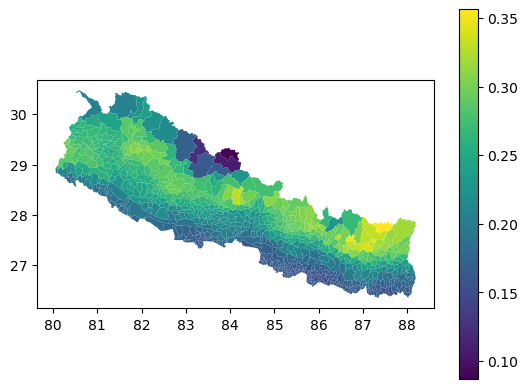

In [26]:
parquet_file.plot(column="day_22_daily_mean", legend=True)

In [ ]:
#| export
@hydra.main(version_base=None, config_path="../../conf", config_name="config")
def main(cfg: DictConfig) -> None:
    # Parse command-line arguments
    input_file = str(snakemake.input[0])  # First input file
    output_file = str(snakemake.output[0])
    geography = str(snakemake.params.geography)
    aggregation_variable = str(snakemake.params.variable)

    variables_dict = {
        "2m_temperature": "t2m",
        "2m_dewpoint_temperature": "d2m",
        "volumetric_soil_water_layer_1": "swvl1",
        "total_precipitation": "tp"
    }

    cfg['query']['geography'] = geography
    
    aggregate_data(cfg, input_file=input_file, output_file=output_file, exposure_variable=variables_dict[aggregation_variable])

In [ ]:
#| export
#| eval: false
try: from nbdev.imports import IN_NOTEBOOK
except: IN_NOTEBOOK=False

if __name__ == "__main__" and not IN_NOTEBOOK:
    main()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()